Device: cpu
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Usage: python resnet.py <argument>
No argument given, presuming --full-test
Accuracy of the network on the 10000 test images: 55.35%
Accuracy of the network on the 10000 test images: 73.09%
Accuracy of the network on the 10000 test images: 80.72%
Accuracy of the network on the 10000 test images: 84.24%
Accuracy of the network on the 10000 test images: 83.42%


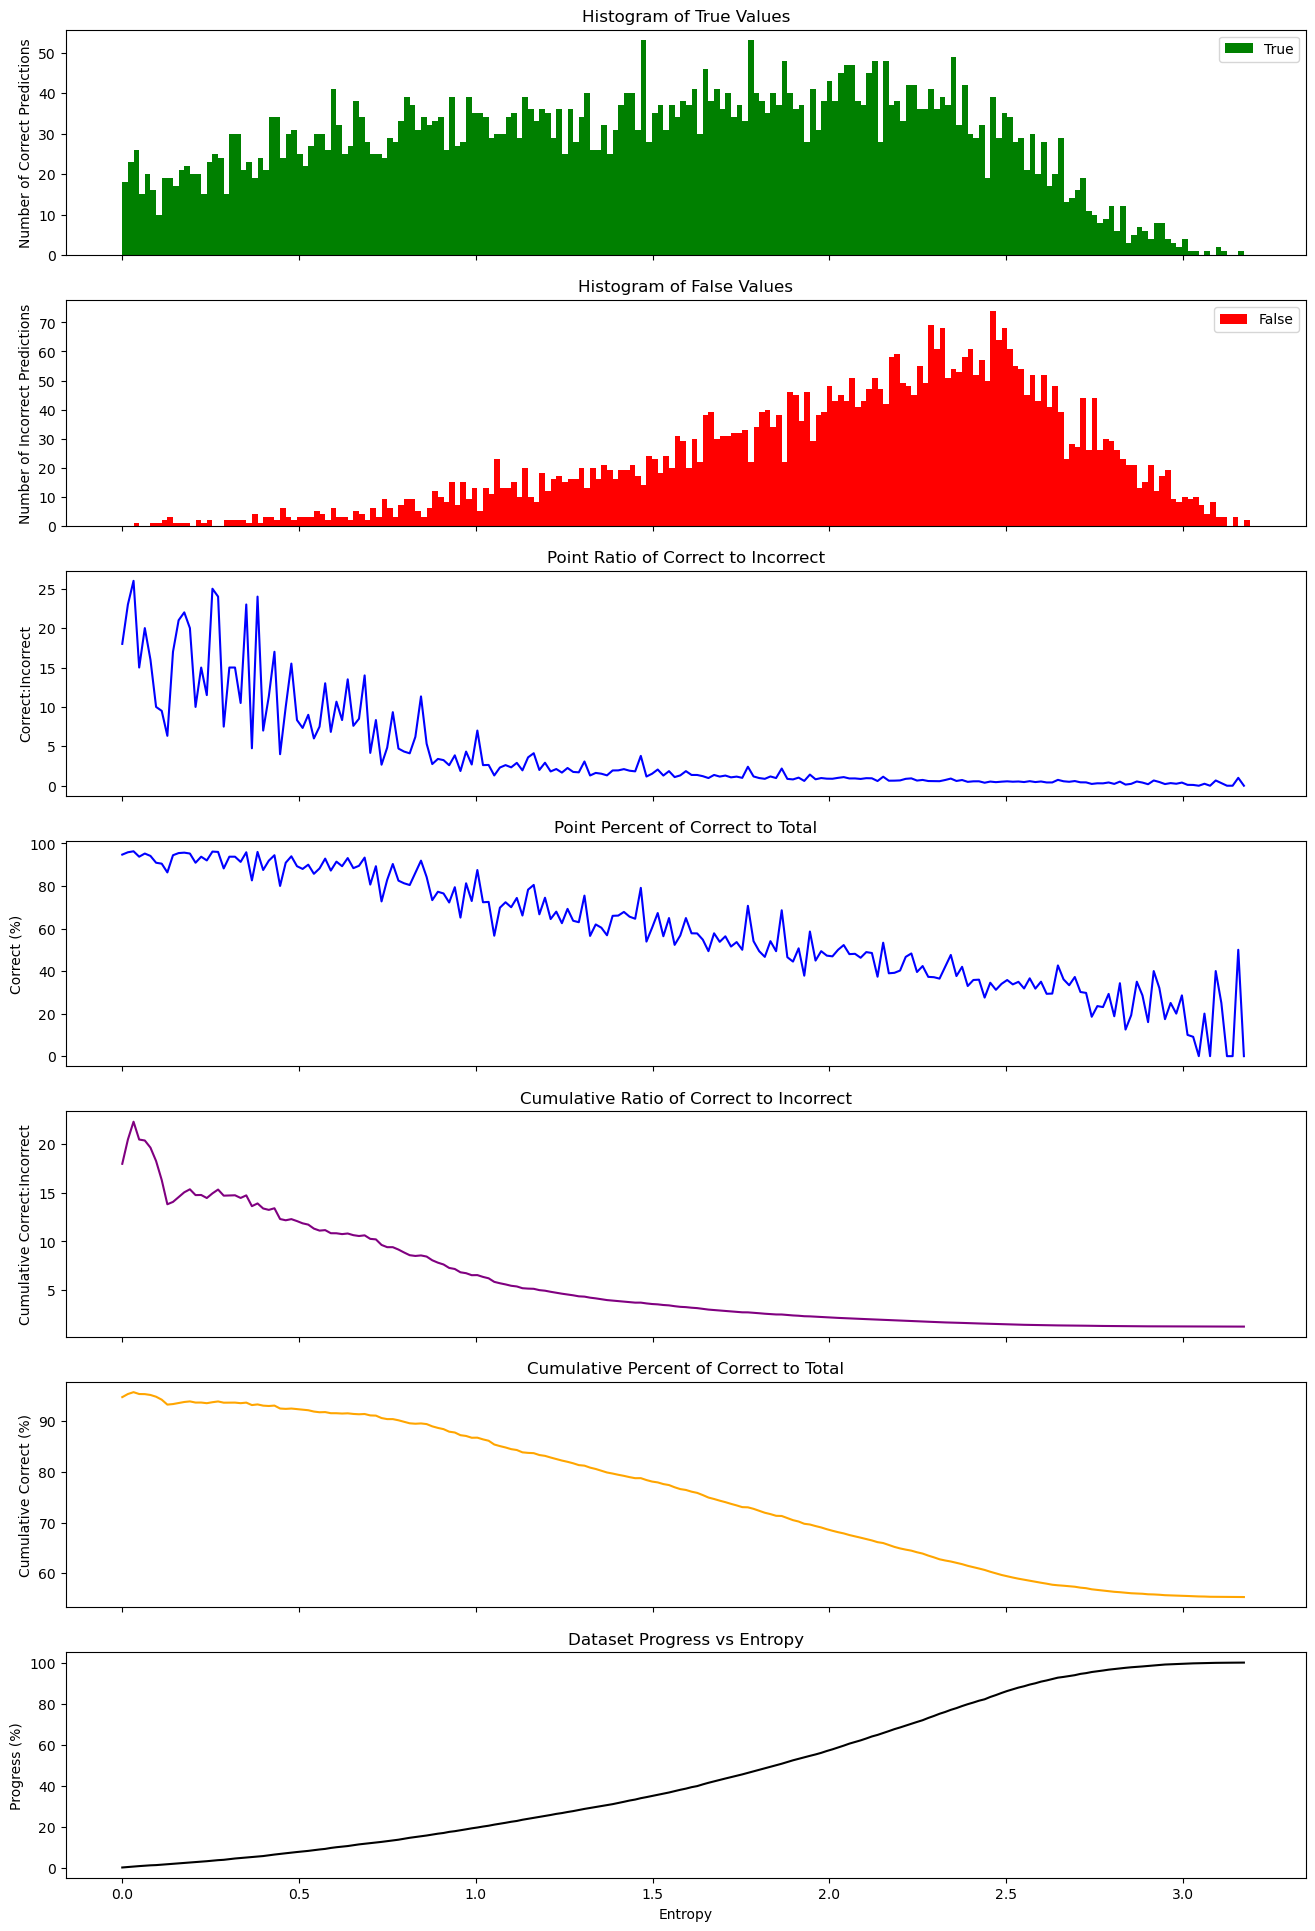

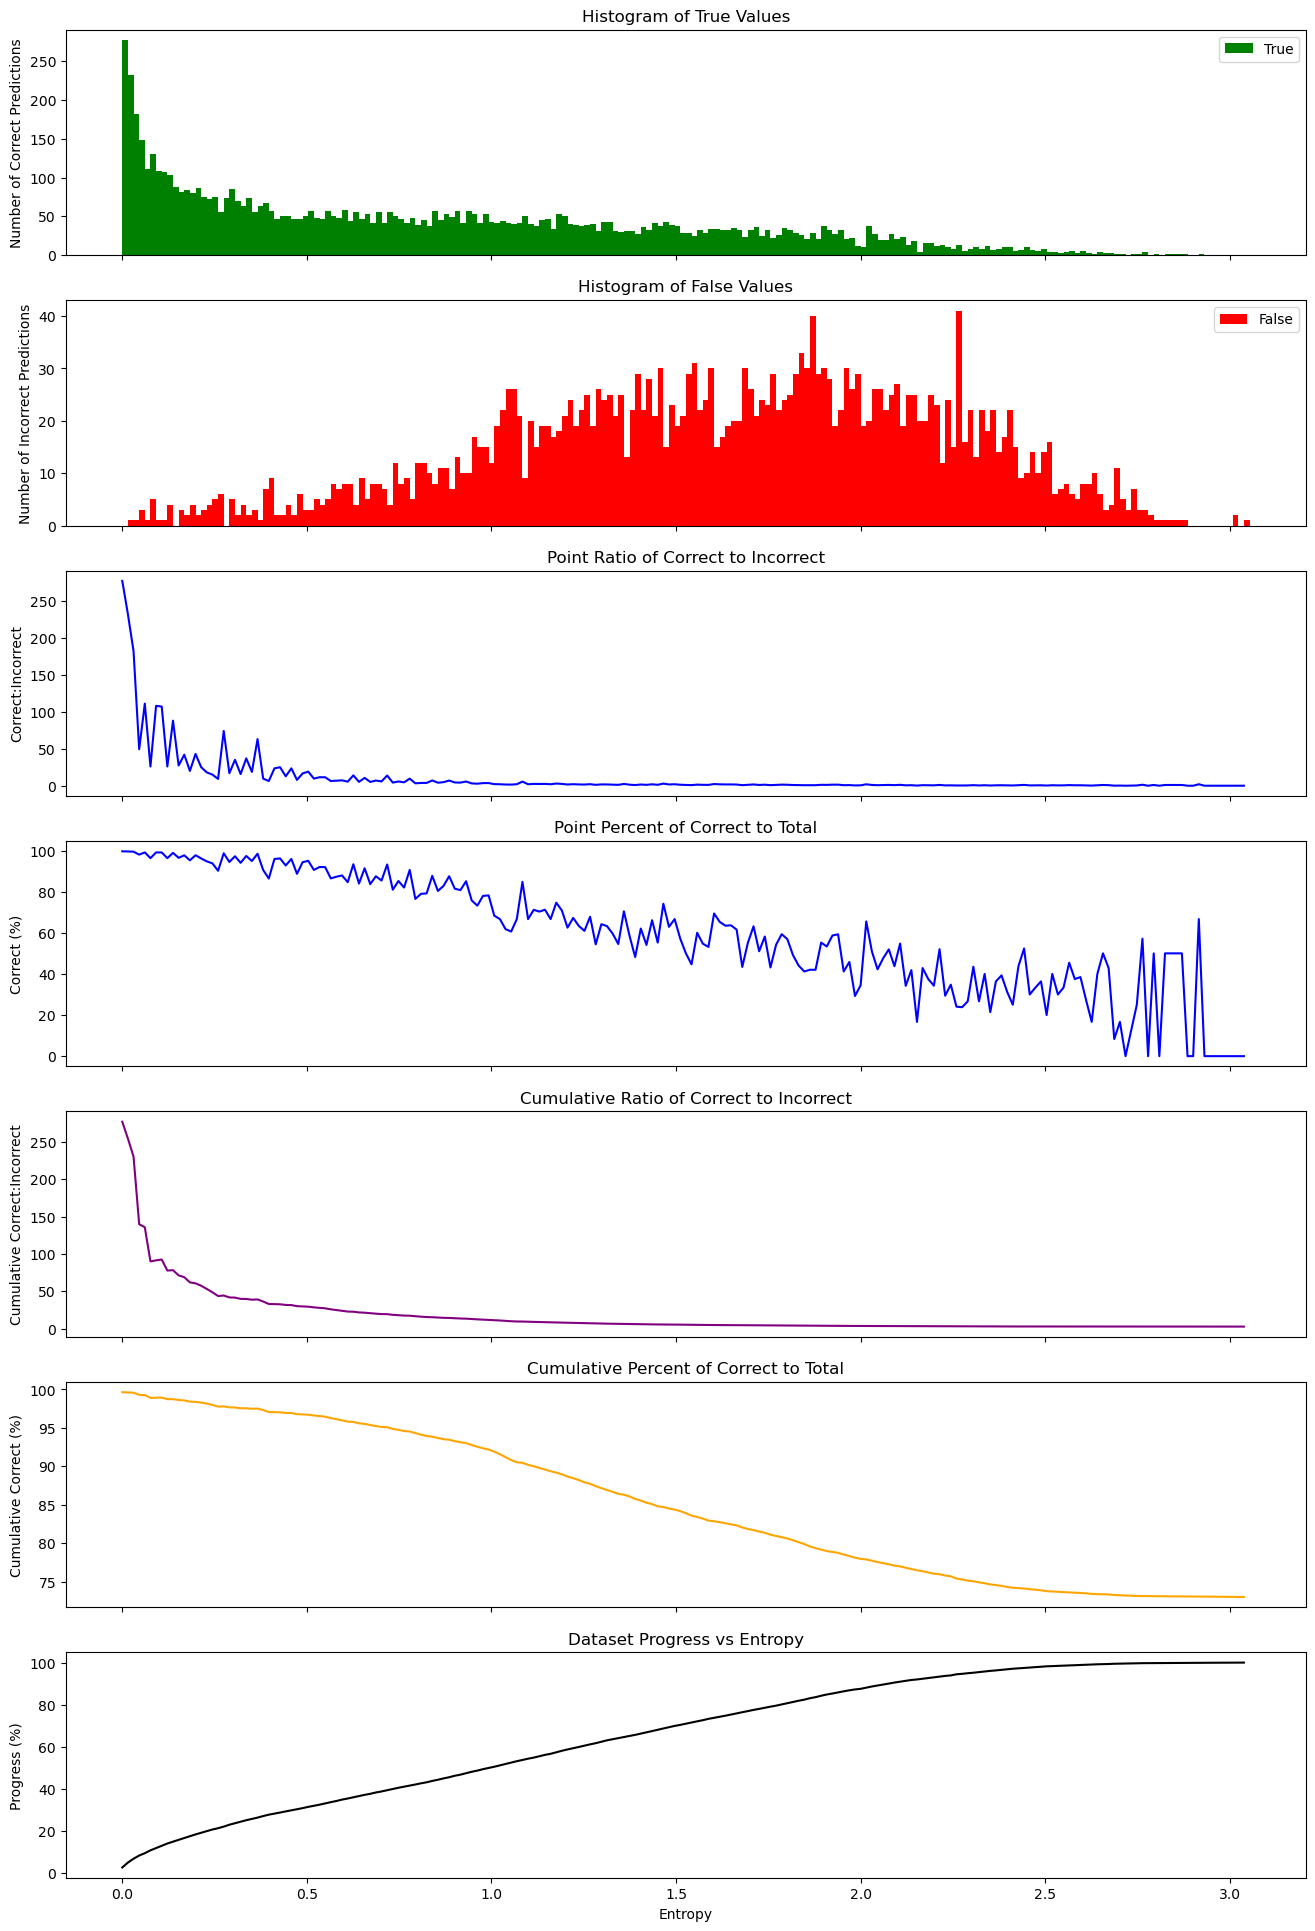

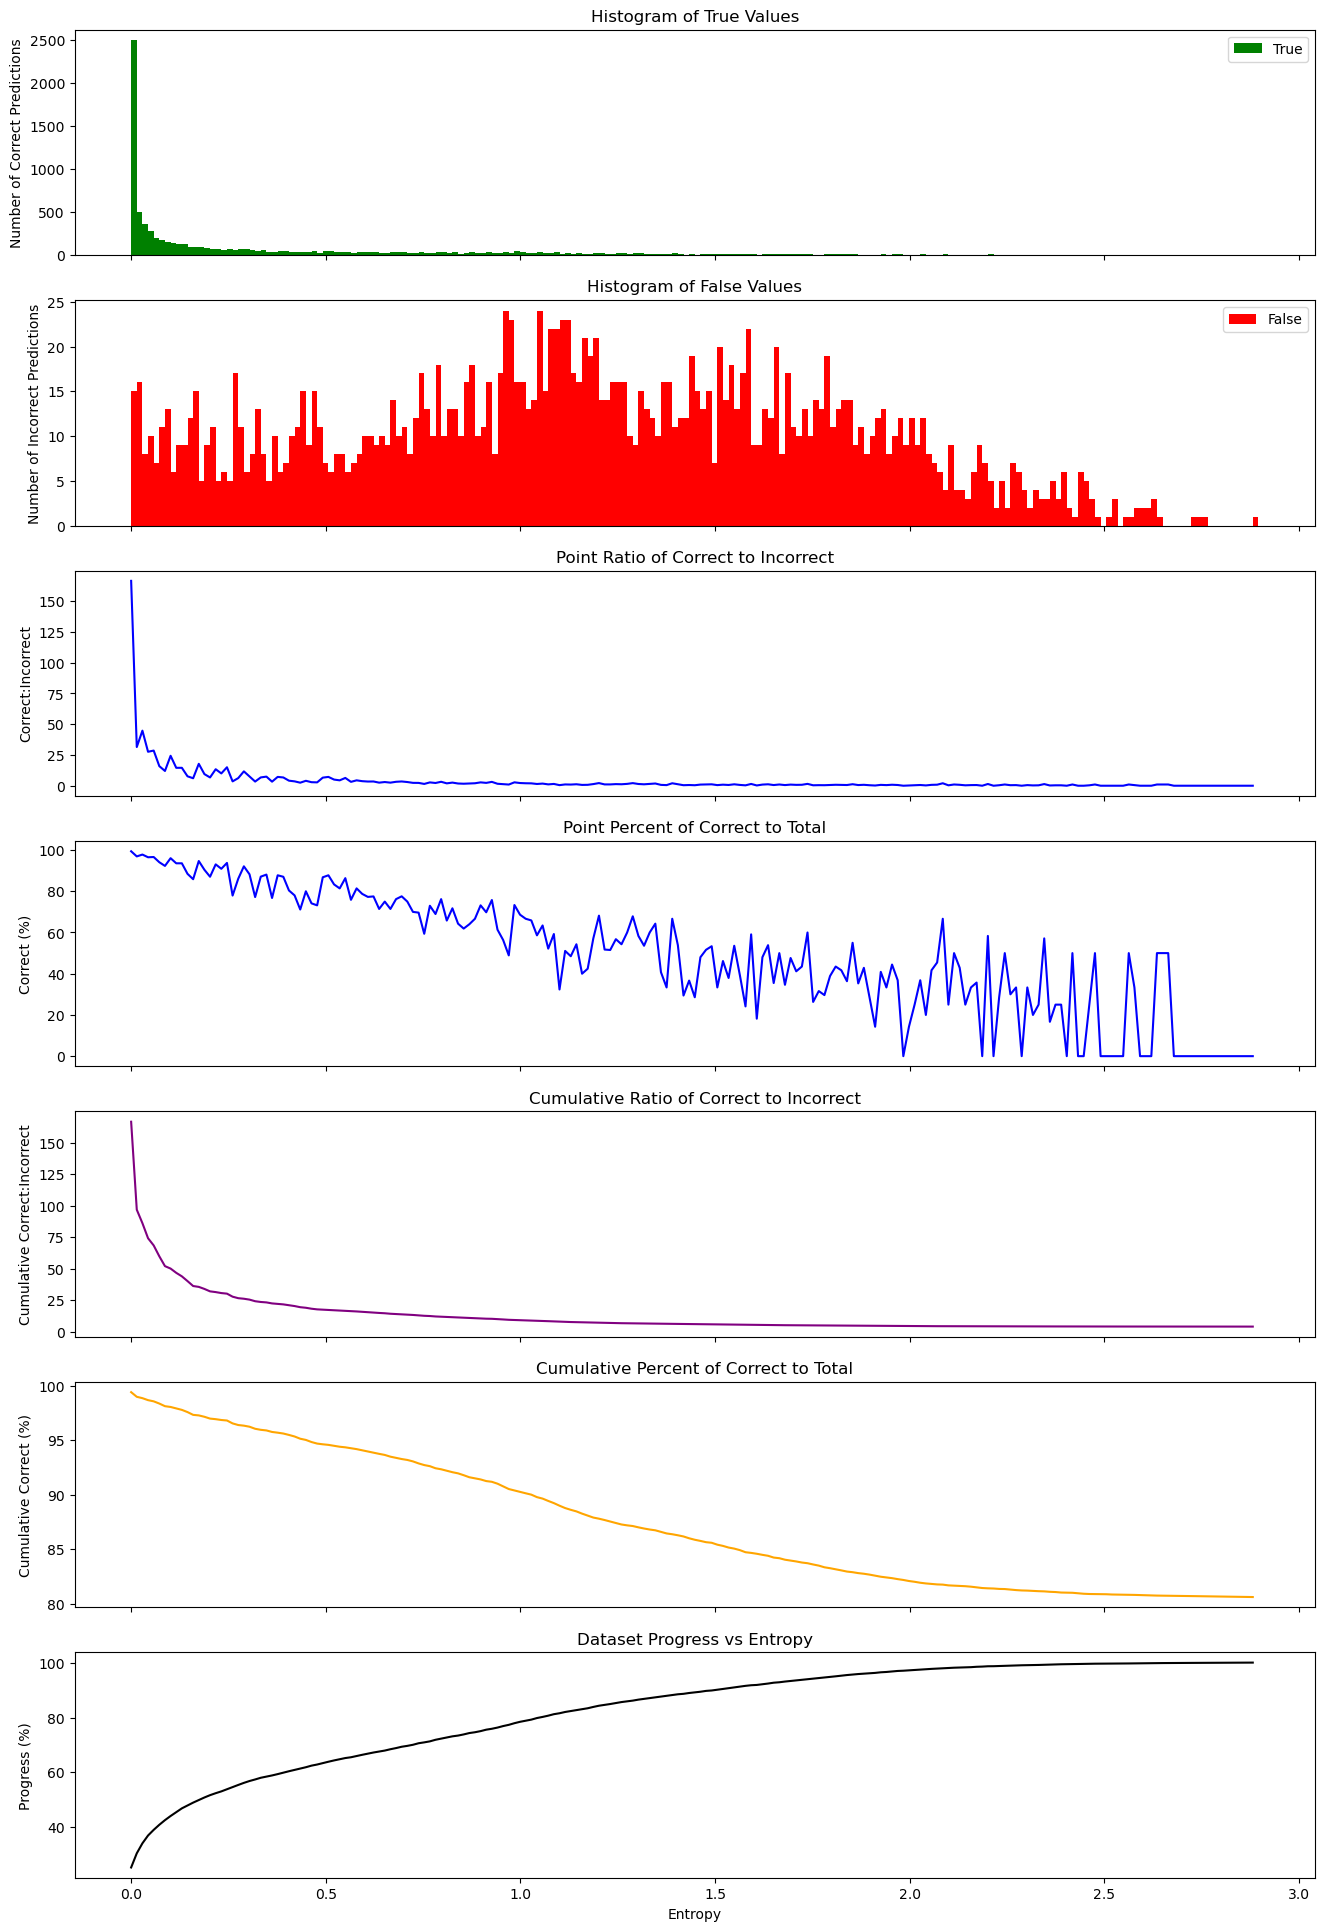

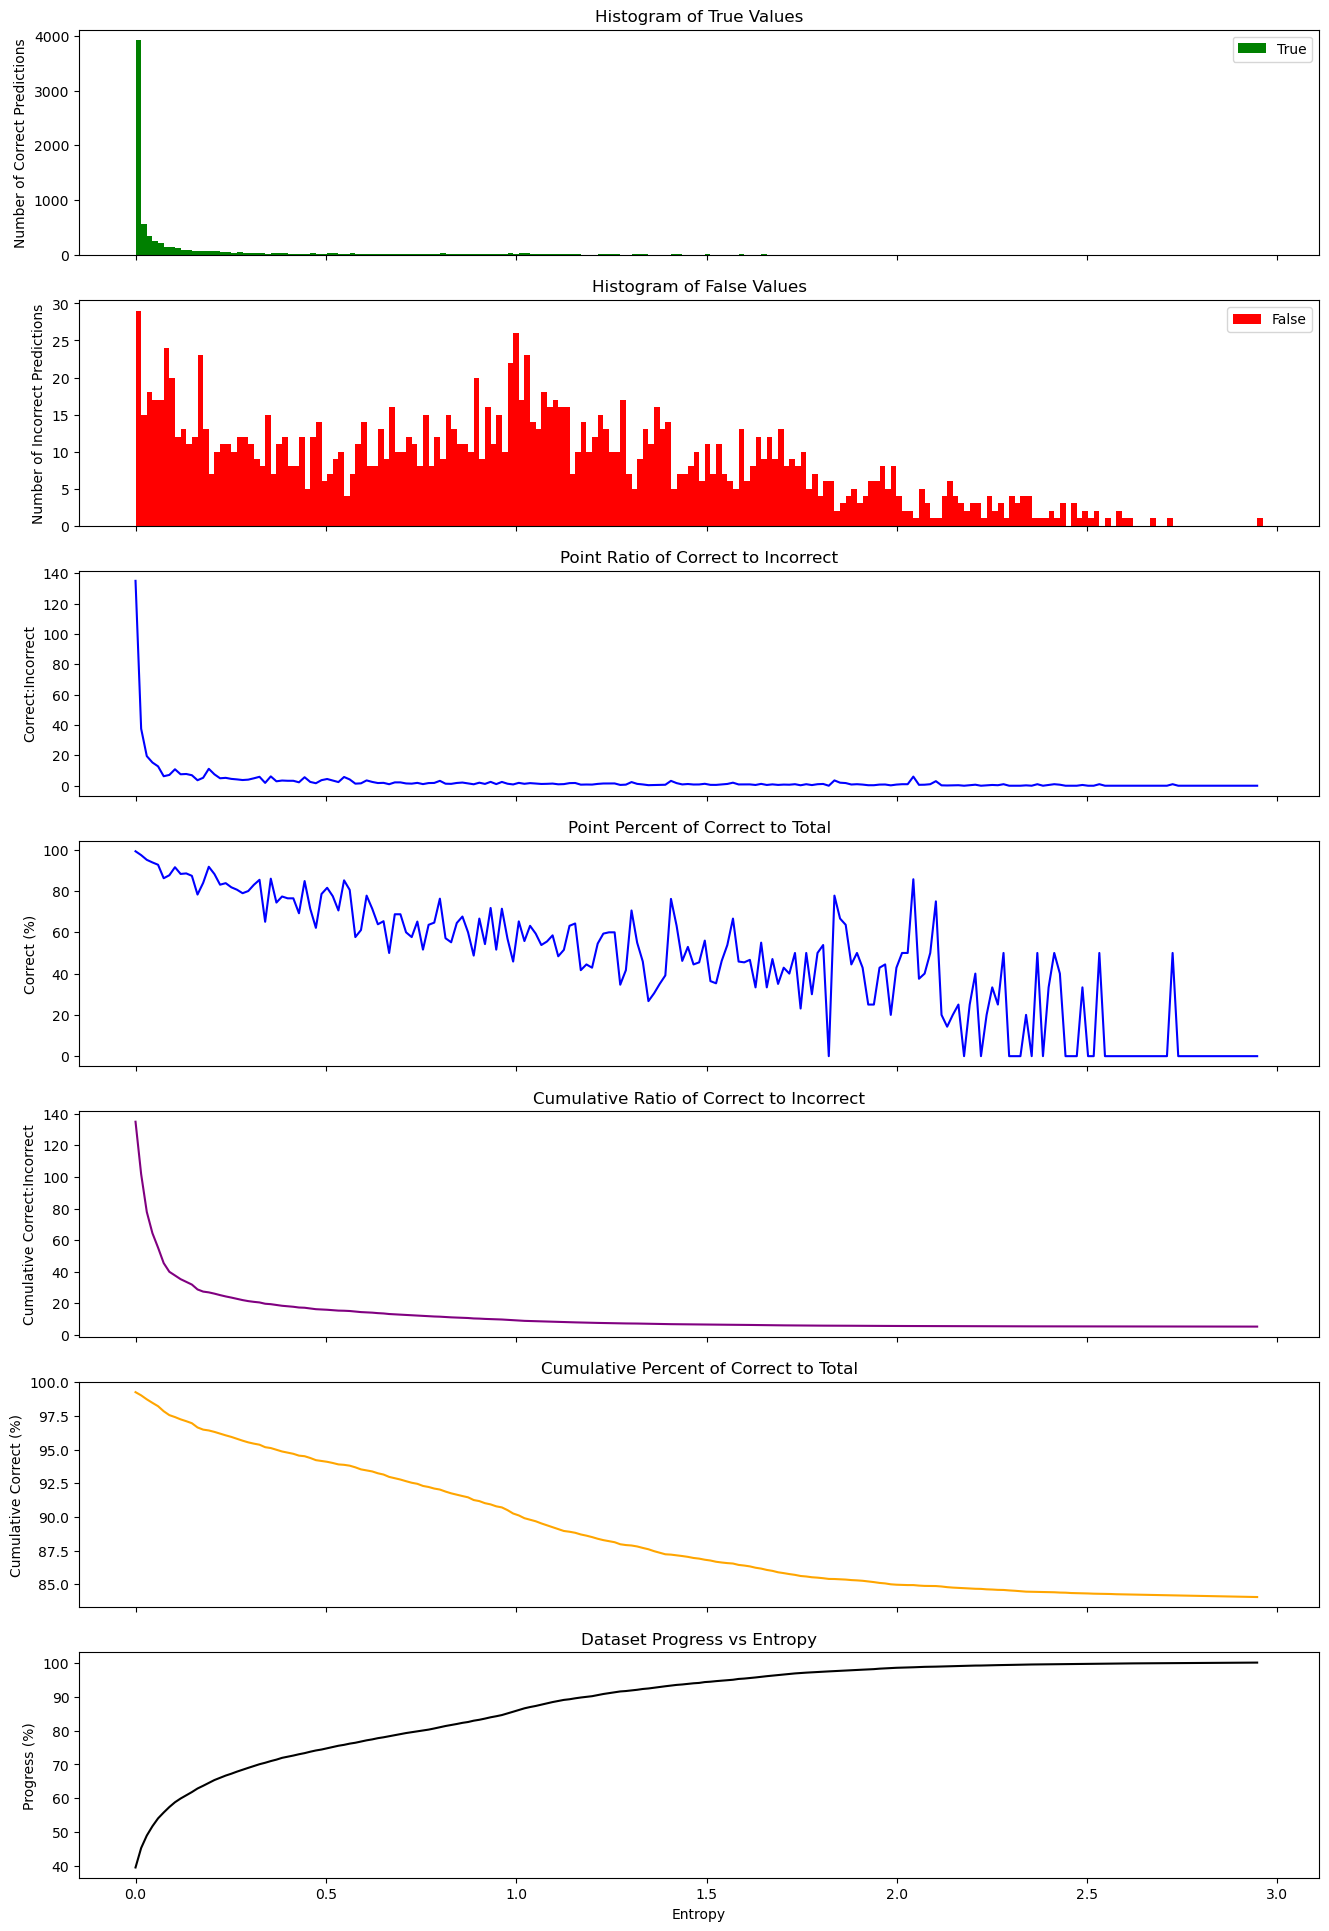

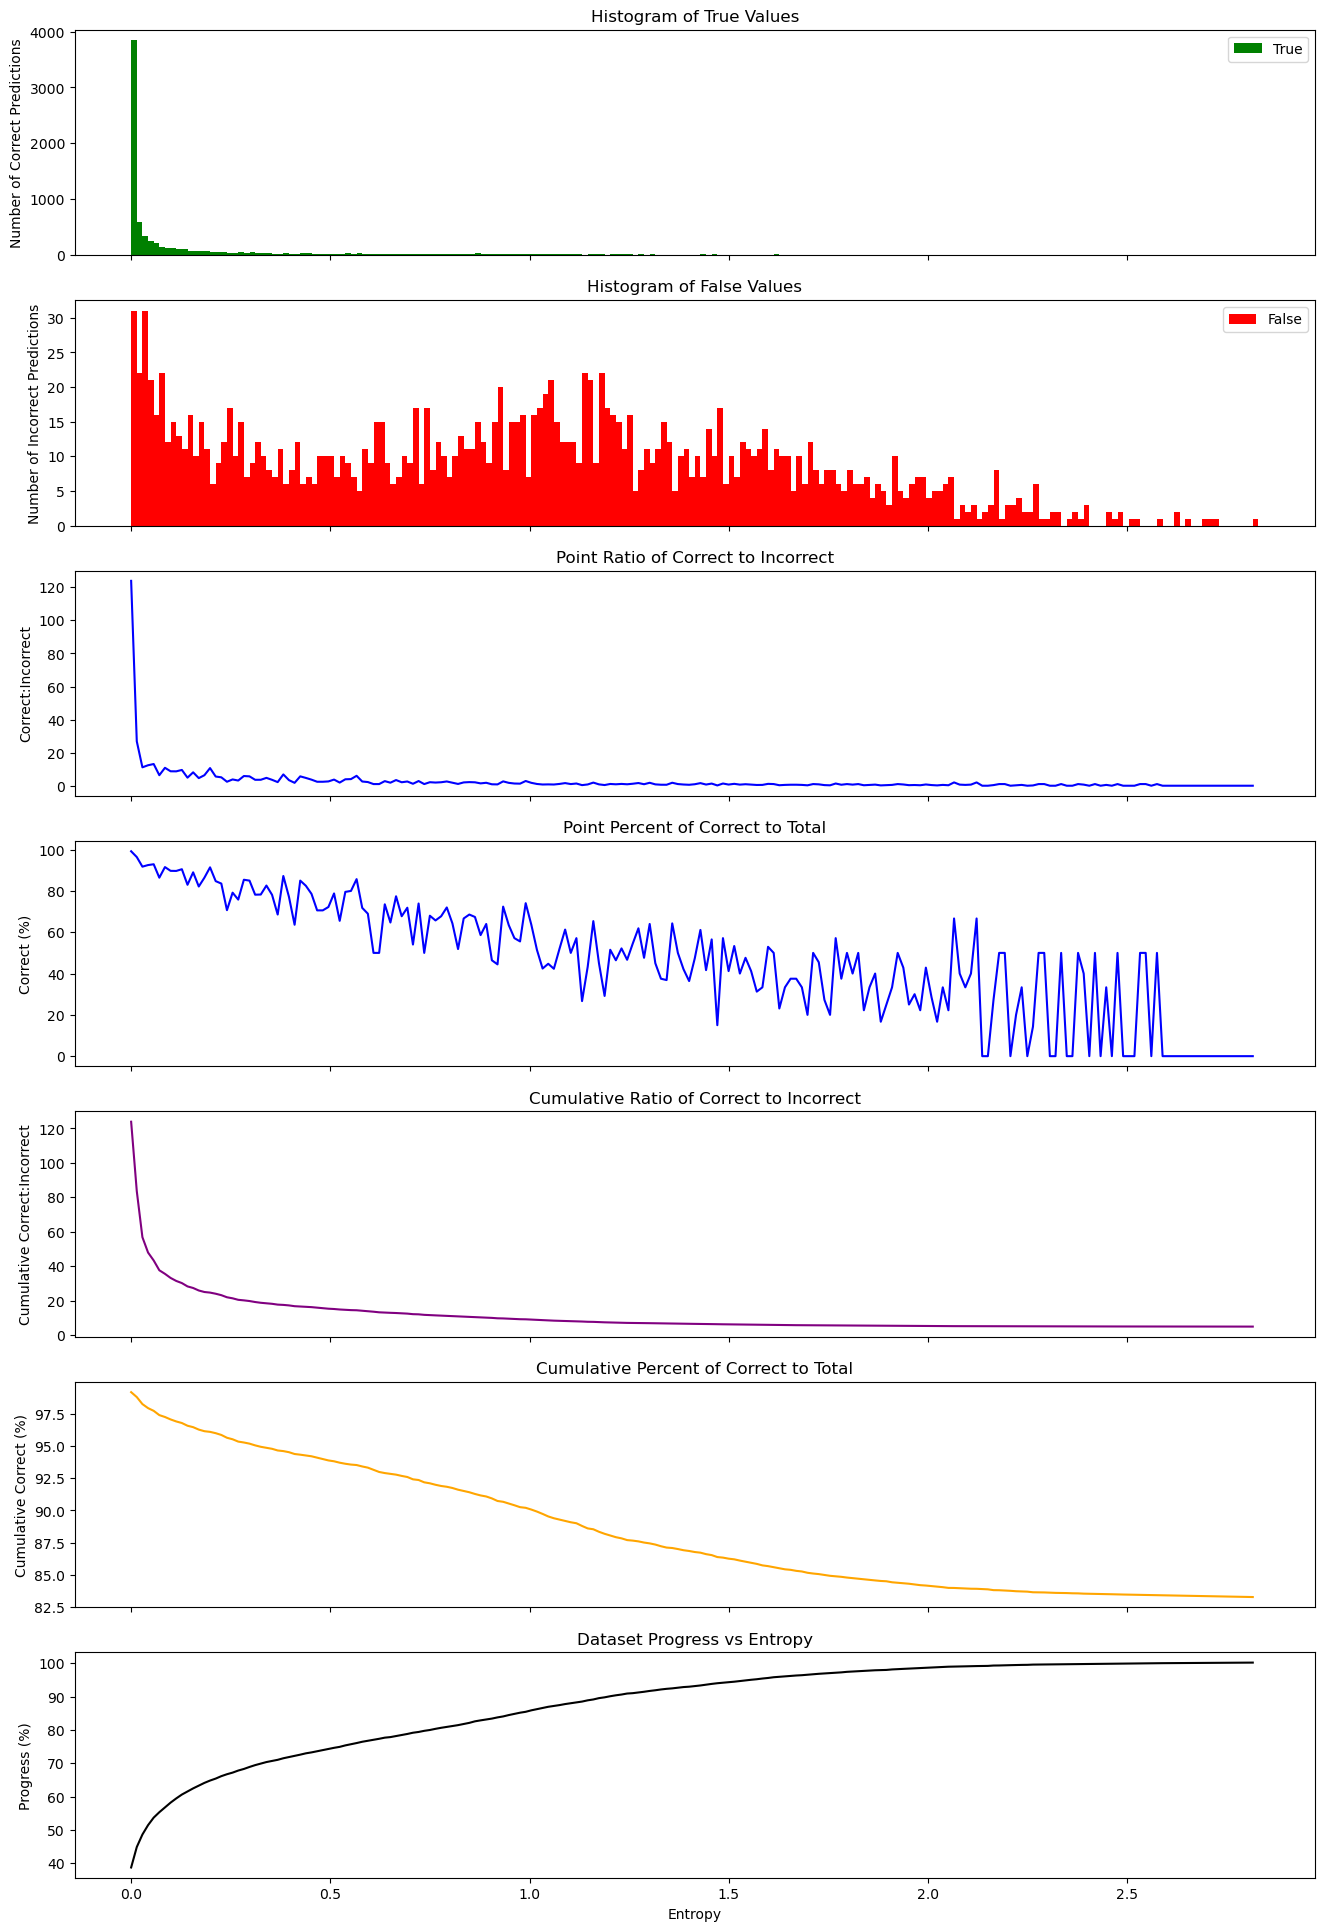

In [74]:
# Done using the following tutorial, not my own work
# https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import sys
import time
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from math import log2
import json
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

def data_loader(data_dir, batch_size, random_seed=42, valid_size=0.1, shuffle=True, test=False):
    # Values specific to CIFAR-10 dataset
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])

    # define transforms
    transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), normalize])

    if test:
        dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    valid_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

# CIFAR10 dataset 
train_loader, valid_loader = data_loader(data_dir='./data', batch_size=64)
test_loader = data_loader(data_dir='./data', batch_size=64, test=True)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

class ResnetLayer1(ResNet):
    def __init__(self, block, layers, num_classes = 10):
        super(ResnetLayer1, self).__init__(block, layers, num_classes = 10)
        # TODO: I need to let this error first to get the correct number to put in
        # Do this programatically in forward
        self.linear = nn.Linear(160000, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        # Avgpool and view shouldn't be needed here according to BranchyNet
        # TODO: Also get rid of this when doing the above TODO as I will know
        # The dimensions of x
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

class ResnetLayer2(ResNet):
    def __init__(self, block, layers, num_classes = 10):
        super(ResnetLayer2, self).__init__(block, layers, num_classes = 10)
        self.linear = nn.Linear(61952, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

class ResnetLayer3(ResNet):
    def __init__(self, block, layers, num_classes = 10):
        super(ResnetLayer3, self).__init__(block, layers, num_classes = 10)
        self.linear = nn.Linear(16384, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

class ResnetLayer4(ResNet):
    def __init__(self, block, layers, num_classes = 10):
        super(ResnetLayer4, self).__init__(block, layers, num_classes = 10)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

def train(model):
    model.train()
    
    learning_rate = 0.01
    weight_decay = 0.001
    momentum = 0.9
    lr_decay = 0.99
    dl_threshold = 1e-5

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

    total_step = len(train_loader)

    prev_loss = float('inf')
    epoch = 0

    while True:
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 
            
        # Check for convergence based on the change in loss
        if abs(prev_loss - loss.item()) < dl_threshold:
            print(f"Training stopped as the change in loss is smaller than the threshold ({dl_threshold})")
            break

        prev_loss = loss.item()
        epoch += 1
        
        print(f"Epoch: {epoch}, Loss: {prev_loss:.5f}")

        # Update learning rate
        lr_scheduler.step()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))
        
def test(model, model_name):
    entropyVsCorrectness = {}
    j = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            y_hat = torch.nn.functional.softmax(outputs, dim=1)
            entropy = -torch.sum(y_hat * torch.log2(y_hat), dim=1)
            
            _, predicted = torch.max(outputs.data, 1)
            
            for a, b in zip(entropy, predicted == labels):
                entropyVsCorrectness[j] = [a.item(), b.item()]
                j += 1

        json_data = json.dumps(entropyVsCorrectness)
        with open(f"{model_name}-{int(time.time())}.json", "a") as file:
            file.write(json_data + "\n")

def graphResults(correctDict):
    true_list = []
    false_list = []

    for key, value in correctDict.items():
        if value[1] is True:
            true_list.append(value[0])
        else:
            false_list.append(value[0])

    true_list.sort()
    false_list.sort()
    
    total_list = np.sort(np.concatenate([true_list, false_list]))
    bins = np.histogram_bin_edges(total_list, bins=200)

    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, sharex=True, figsize=(16,24))
    # fig, (ax7) = plt.subplots(1, 1)

    true_bin_values, _, _ = ax1.hist(true_list, color="green", bins=bins, label="True")
    ax1.legend()
    ax1.set_title("Histogram of True Values")
    ax1.set_ylabel("Number of Correct Predictions")

    false_bin_values, _, _ = ax2.hist(false_list, color="red", bins=bins, label="False")
    ax2.legend()
    ax2.set_title("Histogram of False Values")
    ax2.set_ylabel("Number of Incorrect Predictions")

    # Fix for divide by 0
    # Should this be done differently
    false_bin_values = [x if x != 0 else 1 for x in false_bin_values]

    bin_ratios = true_bin_values / false_bin_values
    ax3.plot(bins[:-1], bin_ratios, color="blue")
    ax3.set_title("Point Ratio of Correct to Incorrect")
    ax3.set_ylabel("Correct:Incorrect")

    bin_ratios = 100* true_bin_values / (true_bin_values + false_bin_values)
    ax4.plot(bins[:-1], bin_ratios, color="blue")
    ax4.set_title("Point Percent of Correct to Total")
    ax4.set_ylabel("Correct (%)")

    cumulative_ratios = np.cumsum(true_bin_values) / np.cumsum(false_bin_values)
    ax5.plot(bins[:-1], cumulative_ratios, color="purple")
    ax5.set_title("Cumulative Ratio of Correct to Incorrect")
    ax5.set_ylabel("Cumulative Correct:Incorrect")

    cumulative_total = 100 * np.cumsum(true_bin_values) / np.cumsum(true_bin_values + false_bin_values)
    ax6.plot(bins[:-1], cumulative_total, color="orange")
    ax6.set_title("Cumulative Percent of Correct to Total")
    ax6.set_ylabel("Cumulative Correct (%)")

    ax7.plot(bins[:-1], 100*np.cumsum(true_bin_values + false_bin_values)/10000, color="black")
    ax7.set_title("Dataset Progress vs Entropy")
    ax7.set_ylabel("Progress (%)")
    
    # ax7.plot(100 * np.cumsum(true_bin_values) / np.cumsum(true_bin_values + false_bin_values), 100*np.cumsum(true_bin_values + false_bin_values)/10000, color="blue")
    # ax7.set_title("Cumulative Sum of Total Answers")
    # ax7.set_xlabel("Accuracy (%)")
    # ax7.set_ylabel("Total of Dataset (%)")

    plt.xlabel("Entropy")

    total = len(true_list) + len(false_list)
    print(f"Accuracy of the network on the {total} test images: {100 * len(true_list) / total}%")

def graphBranch(correctDict, ax1, ax2, label):
    true_list = []
    false_list = []

    for key, value in correctDict.items():
        if value[1] is True:
            true_list.append(value[0])
        else:
            false_list.append(value[0])

    true_list.sort()
    false_list.sort()
    
    total_list = np.sort(np.concatenate([true_list, false_list]))
    bins = np.histogram_bin_edges(total_list, bins=500)

    true_bin_values, _ = np.histogram(true_list, bins=bins)
    false_bin_values, _ = np.histogram(false_list, bins=bins)

    color = np.random.rand(3,)

    ax1.plot(100 * np.cumsum(true_bin_values) / np.cumsum(true_bin_values + false_bin_values), 100*np.cumsum(true_bin_values + false_bin_values)/10000, label=label, color=color)
    ax2.plot(100 * np.cumsum(true_bin_values) / np.cumsum(true_bin_values + false_bin_values), bins[:-1], color=color)

def fullTest():
    model0state = torch.load("models/model0", map_location=device)
    model1state = torch.load("models/model1", map_location=device)
    model2state = torch.load("models/model2", map_location=device)
    model3state = torch.load("models/model3", map_location=device)
    modelfullstate = torch.load("models/modelfull", map_location=device)

    model0 = ResnetLayer1(ResidualBlock, [3, 4, 6, 3]).to(device)
    model1 = ResnetLayer2(ResidualBlock, [3, 4, 6, 3]).to(device)
    model2 = ResnetLayer3(ResidualBlock, [3, 4, 6, 3]).to(device)
    model3 = ResnetLayer4(ResidualBlock, [3, 4, 6, 3]).to(device)
    modelfull = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

    model0.load_state_dict(model0state)
    model1.load_state_dict(model1state)
    model2.load_state_dict(model2state)
    model3.load_state_dict(model3state)
    modelfull.load_state_dict(modelfullstate)

    models = [model0, model1, model2, model3, modelfull]
    # i = 0
    # for model in models:
    #     test(model, f"{i}")
    #     i += 1
        
    file_pattern = '*.json'
    file_list = glob.glob(file_pattern)
    file_list.sort()

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
    # ax1.set_title("Cumulative Sum of Total Answers")
    # ax1.set_xlabel("Accuracy (%)")
    # ax1.set_ylabel("Total of Dataset (%)")

    # ax2.set_title("Entropy vs Accuracy")
    # ax2.set_xlabel("Accuracy (%)")
    # ax2.set_ylabel("Entropy ()")

    # try:
    for file_path in file_list:
        with open(file_path, 'r') as file:
            dictionary = json.load(file)
            graphResults(dictionary)
            # graphBranch(dictionary, ax1, ax2, file_path)

    # ax1.legend()
    plt.show()
    # except:
    #     pass

def fullTrain():
# This is ResNet50
# Resnet50, Resnet101 and resnet152 all have a similar architecture, Resnet18 and Resnet34 are different
# Not an issue for me, just use the bigger models since branches shouldnt matter on smaller models
# Come back and try the smaller ones later when the branches actually work
    model0 = ResnetLayer1(ResidualBlock, [3, 4, 6, 3]).to(device).train()
    train(model0)
    model0.eval()
    # TODO: Save the architecture as well
    torch.save(model0.state_dict(), "models/model0")

    model1 = ResnetLayer2(ResidualBlock, [3, 4, 6, 3]).to(device).train()
    train(model1)
    model1.eval()
    torch.save(model1.state_dict(), "models/model1")

    model2 = ResnetLayer3(ResidualBlock, [3, 4, 6, 3]).to(device).train()
    train(model2)
    model2.eval()
    torch.save(model2.state_dict(), "models/model2")

    model3 = ResnetLayer4(ResidualBlock, [3, 4, 6, 3]).to(device).train()
    train(model3)
    model3.eval()
    torch.save(model3.state_dict(), "models/model3")

    modelfull = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device).train()
    train(modelfull)
    modelfull.eval()
    torch.save(modelfull.state_dict(), "models/modelfull")

def main():
    if len(sys.argv) != 2:
        print("Usage: python resnet.py <argument>")

    argument = sys.argv[1]

    if argument == "--full-train":
        fullTrain()
    elif argument == "--full-test":
        fullTest()
    else:
        print(f"No argument given, presuming --full-test")
        fullTest()

if __name__ == "__main__":
    main()